# Paper Figures: Figure 4 - Sigmoidal Transitions in Cluster Probability

This notebook generates publication-ready figures for cluster probability transitions using sigmoidal fitting based on data assembled by `src/assemble_all_data.py`.

**Figure 4: Cluster Transitions** — Sigmoidal fits to cluster probability curves showing how animals transition between neural response clusters across trials.

In [8]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from scipy.optimize import curve_fit

# Add src to path for importing local modules
sys.path.insert(0, str(Path("../src").resolve()))

from figure_config import (
    configure_matplotlib, COLORS, HEATMAP_CMAP,
    DATAFOLDER, RESULTSFOLDER, FIGSFOLDER,
    SAVE_FIGS
)
from figure_plotting import (
    save_figure, scale_vlim_to_data
)

# Configure matplotlib
configure_matplotlib()
colors = COLORS  # Use shared color palette
custom_cmap = HEATMAP_CMAP  # Use shared colormap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Assembled Data

Load the complete dataset from the pickle file generated by the assembly script.

In [9]:
assembled_data_path = DATAFOLDER / "assembled_data.pickle"

with open(assembled_data_path, "rb") as f:
    data = dill.load(f)

# Extract main components
x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_behav = data["snips_behav"]
fits_df = data["fits_df"]
metadata = data.get("metadata", {})

print(f"Loaded assembled data from {assembled_data_path}")
print(f"\nData structure:")
print(f"  - x_array shape: {x_array.shape}")
print(f"  - snips_photo shape: {snips_photo.shape}")
print(f"  - x_array columns: {x_array.columns.tolist()}")
print(f"  - Number of trials: {len(x_array)}")
print(f"  - Clusters: {sorted(x_array.cluster_photo.unique())}")

print(f"\nFits DataFrame info:")
print(f"  - fits_df shape: {fits_df.shape if fits_df is not None else 'None'}")
print(f"  - fits_df columns: {fits_df.columns.tolist() if fits_df is not None else 'None'}")
if fits_df is not None:
    print(f"\nSample of fits_df:")
    print(fits_df.head())

Loaded assembled data from ..\data\assembled_data.pickle

Data structure:
  - x_array shape: (1960, 12)
  - snips_photo shape: (1960, 200)
  - x_array columns: ['trial', 'id', 'condition', 'infusiontype', 'sex', 'cluster_photo', 'clusterness_photo', 'euclidean_diff', 'auc_snips', 'auc_vel', 'time_moving', 'trial_aligned']
  - Number of trials: 1960
  - Clusters: [np.int64(0), np.int64(1)]

Fits DataFrame info:
  - fits_df shape: (8, 10)
  - fits_df columns: ['id', 'A', 'L', 'x0_norm', 'x0_orig', 'k', 'model', 'r_squared', 'success', 'note']

Sample of fits_df:
     id         A         L   x0_norm    x0_orig          k      model  \
0  PB26 -0.018830  0.923460 -0.087254  22.766043 -10.000000  logistic4   
2  PB30  0.083253  1.030909 -0.842827  12.080631 -10.000000  logistic4   
3  PB31 -0.027289  0.986766 -0.035364  23.499884  -4.822829  logistic4   
4  PB46  0.065452  0.649679 -0.304863  19.688586 -10.000000  logistic4   
6  PB71  0.048542  0.949934 -0.742174  13.504078 -10.000000  lo

## Figure 4: Sigmoidal Transitions in Cluster Probability

Fitting sigmoid functions to cluster probability curves reveals how quickly animals transition between neural response patterns across trials during sodium appetite states.

In [3]:
# Verify sigmoid function is available
def sigmoid(x, A, L, x0, k):
    """4-parameter logistic function (matches assembly script)."""
    return A + (L - A) / (1 + np.exp(-k * (x - x0)))

# Check what's in fits_df from assembly
print(f"Fitted transitions available: {len(fits_df)} animals")
print(f"Columns in fits_df: {fits_df.columns.tolist()}")
print(f"\nSample of fits_df:")
print(fits_df.head())

Fitted transitions available: 8 animals
Columns in fits_df: ['id', 'A', 'L', 'x0_norm', 'x0_orig', 'k', 'model', 'r_squared', 'success', 'note']

Sample of fits_df:
     id         A         L   x0_norm    x0_orig          k      model  \
0  PB26 -0.018830  0.923460 -0.087254  22.766043 -10.000000  logistic4   
2  PB30  0.083253  1.030909 -0.842827  12.080631 -10.000000  logistic4   
3  PB31 -0.027289  0.986766 -0.035364  23.499884  -4.822829  logistic4   
4  PB46  0.065452  0.649679 -0.304863  19.688586 -10.000000  logistic4   
6  PB71  0.048542  0.949934 -0.742174  13.504078 -10.000000  logistic4   

   r_squared  success note  
0   0.799788     True       
2   0.661720     True       
3   0.785102     True       
4   0.343041     True       
6   0.670661     True       


### 4A. Cluster Probability by Condition

In [4]:
# fits_df already contains only deplete + 45NaCl animals from assembly script
if fits_df is not None and len(fits_df) > 0:
    print(f"Loaded {len(fits_df)} deplete + 45NaCl animals with sigmoid fits")
    print(f"Columns in fits_df: {fits_df.columns.tolist()}")
    
    print(f"\nTransition Parameters Summary (Deplete + 45NaCl):")
    print(f"  x0 (transition point): {fits_df['x0_orig'].mean():.1f} ± {fits_df['x0_orig'].std():.1f} trials")
    print(f"  k (steepness):         {fits_df['k'].mean():.3f} ± {fits_df['k'].std():.3f}")
    print(f"  R² (fit quality):      {fits_df['r_squared'].mean():.3f} ± {fits_df['r_squared'].std():.3f}")
    
    print(f"\nIndividual animal fits:")
    for idx, row in fits_df.iterrows():
        animal_id = row.get('id', row.get('animal_id', f'animal_{idx}'))
        print(f"  {animal_id:5s} | x0={row['x0_orig']:6.1f}, k={row['k']:6.2f}, R²={row['r_squared']:5.3f}")
else:
    print("Warning: fits_df is empty or None - transition fits not available in assembled data")

Loaded 8 deplete + 45NaCl animals with sigmoid fits
Columns in fits_df: ['id', 'A', 'L', 'x0_norm', 'x0_orig', 'k', 'model', 'r_squared', 'success', 'note']

Transition Parameters Summary (Deplete + 45NaCl):
  x0 (transition point): 17.4 ± 4.6 trials
  k (steepness):         -8.249 ± 3.386
  R² (fit quality):      0.633 ± 0.228

Individual animal fits:
  PB26  | x0=  22.8, k=-10.00, R²=0.800
  PB30  | x0=  12.1, k=-10.00, R²=0.662
  PB31  | x0=  23.5, k= -4.82, R²=0.785
  PB46  | x0=  19.7, k=-10.00, R²=0.343
  PB71  | x0=  13.5, k=-10.00, R²=0.671
  PB72  | x0=  11.5, k=-10.00, R²=0.694
  PB73  | x0=  17.3, k=-10.00, R²=0.879
  PB75  | x0=  18.6, k= -1.17, R²=0.230


### 4B. Representative Transition Curves

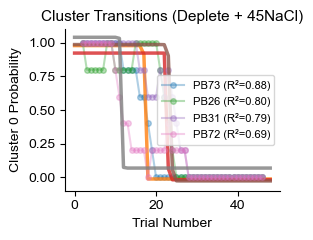

In [5]:
# Plot representative sigmoid fits for deplete + 45NaCl animals
f, ax = plt.subplots(figsize=(3, 2.5))

# Get up to 4 animals with best fit quality
best_fits = fits_df.nlargest(4, 'r_squared')

for idx, (_, row) in enumerate(best_fits.iterrows()):
    animal_id = row.get('id', row.get('animal_id', f'animal_{idx}'))
    
    # Get trials for this animal from x_array
    subset = x_array.query("id == @animal_id & condition == 'deplete' & infusiontype == '45NaCl'").sort_values('trial')
    trial_nums = subset.trial.values
    
    # Calculate cluster probability (cluster 0 = 1, else 0)
    cluster_membership = (subset.cluster_photo.values == 0).astype(int)
    
    # Smooth with rolling window
    window_size = min(5, len(cluster_membership))
    cluster_prob = pd.Series(cluster_membership).rolling(window=window_size, center=True).mean().values
    
    # Plot actual probability
    ax.plot(trial_nums, cluster_prob, 'o-', alpha=0.35, markersize=4, 
            label=f"{animal_id} (R²={row['r_squared']:.2f})")
    
    # Plot fitted sigmoid using stored parameters
    y_fit = sigmoid(trial_nums, row['A'], row['L'], row['x0_orig'], row['k'])
    ax.plot(trial_nums, y_fit, '-', linewidth=2.5, alpha=0.8)

ax.set_xlabel('Trial Number', fontsize=10)
ax.set_ylabel('Cluster 0 Probability', fontsize=10)
ax.set_title('Cluster Transitions (Deplete + 45NaCl)', fontsize=11)
ax.set_ylim([-0.1, 1.1])
ax.legend(fontsize=8, loc='best')
sns.despine(ax=ax)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(f, "fig4b_representative_transitions", FIGSFOLDER)
plt.show()

### 4C. Transition Parameters Summary

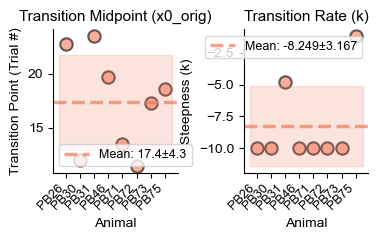

In [6]:
# Summary plots of transition parameters for deplete + 45NaCl animals
f, axes = plt.subplots(1, 2, figsize=(4, 2.5))

x0_data = fits_df['x0_orig'].values
k_data = fits_df['k'].values
animal_labels = fits_df['id'].values if 'id' in fits_df.columns else fits_df['animal_id'].values

# Plot 1: Transition point (x0)
ax = axes[0]
ax.scatter(np.arange(len(x0_data)), x0_data, color=colors[2], s=80, alpha=0.6, edgecolor='k', linewidth=1.5)
ax.axhline(x0_data.mean(), color=colors[2], linestyle='--', linewidth=2.5, alpha=0.7, 
           label=f"Mean: {x0_data.mean():.1f}±{x0_data.std():.1f}")
ax.fill_between([-0.5, len(x0_data)-0.5], 
                 x0_data.mean() - x0_data.std(),
                 x0_data.mean() + x0_data.std(), 
                 color=colors[2], alpha=0.2)
ax.set_xlabel('Animal', fontsize=10)
ax.set_ylabel('Transition Point (Trial #)', fontsize=10)
ax.set_title('Transition Midpoint (x0_orig)', fontsize=11)
ax.set_xticks(range(len(x0_data)))
ax.set_xticklabels(animal_labels, rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=9)
sns.despine(ax=ax)

# Plot 2: Steepness (k)
ax = axes[1]
ax.scatter(np.arange(len(k_data)), k_data, color=colors[2], s=80, alpha=0.6, edgecolor='k', linewidth=1.5)
ax.axhline(k_data.mean(), color=colors[2], linestyle='--', linewidth=2.5, alpha=0.7, 
           label=f"Mean: {k_data.mean():.3f}±{k_data.std():.3f}")
ax.fill_between([-0.5, len(k_data)-0.5],
                 k_data.mean() - k_data.std(),
                 k_data.mean() + k_data.std(),
                 color=colors[2], alpha=0.2)
ax.set_xlabel('Animal', fontsize=10)
ax.set_ylabel('Steepness (k)', fontsize=10)
ax.set_title('Transition Rate (k)', fontsize=11)
ax.set_xticks(range(len(k_data)))
ax.set_xticklabels(animal_labels, rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=9)
sns.despine(ax=ax)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(f, "fig4c_transition_parameters", FIGSFOLDER)
plt.show()

## Save Results

In [7]:
# Export deplete + 45NaCl transition fits for reference
fits_df.to_csv(RESULTSFOLDER / "transition_sigmoid_fits_deplete_45NaCl.csv", index=False)
print(f"Exported transition fits to {RESULTSFOLDER / 'transition_sigmoid_fits_deplete_45NaCl.csv'}")
print(f"\nFigure 4 generation complete!")

Exported transition fits to ..\results\transition_sigmoid_fits_deplete_45NaCl.csv

Figure 4 generation complete!
